# Black boxes

(MyHDL extensions by section5)

Like in Verilog/VHDL, a logic entity that...
  * is 'closed source' (a net list, ...)
  * is resolved at a later stage
  * is a FPGA primitive where only a simulation model might apply
  
is treated and abstracted as a **Black Box**.

## Development aspect

Strategy of **Divide et impera**:
  * Give developer maximum control over what logic should be created
  * ..while providing means to preserve portability
  * Target abstraction: Separate target parameters and implementation rules from design
  * ... but keep code in one place
  * Allow to switch target using one configuration variable


## The Blackbox MyHDL API

* Allows wrapping external `V*HDL`-modules
* Allows to specify a simplified simulation model for a (closed source) IP module
* [Generator classes](#Generator-classes), allowing elegant 'inline' constructions, as
  * Unary reduction operators (no VHDL-built-in!)
  * Gray coding logic 'inline'
  * Bitfield data types and operations
  * Instance of synthesis-specific constructs
* [Parametrizeable implementations](#Parametrizeable-top-level-design) of top level design projects:
  * (Portable) Hardware projects for multiple FPGA architectures
  * Specific Co-Simulation variants
  * Software-Implementations of hardware IP (simulation executables)
* Future music:
  * Bulk signals (automated signal class to HDL record wrapping for complex signals), like busses, port arrays, ..

## Standard 'external' Blackbox

`@autowrap`: A `@blackbox` unit that automatically wraps the function interface (as in VHDL terms: into a component declaration).

* Does not synthesize any of its behavioural description
* Creates a module stub for the synthesis tool (resolved at a later time)
* Returns a simulator model for simulation

In [5]:
import config

In [6]:
from synthesis.yosys.autowrap import autowrap

@autowrap
def OSCG(OSC, **parameter):
    "On-Chip oscillator"

    # half period in pico seconds
    C_OSCP = 1613
    oscb = Signal(bool(0))

    try:
        DIV = parameter['DIV']
    except KeyError:
        print("No 'DIV' parameter given for divider, using default 128")
        DIV = 128

    halfp = C_OSCP * DIV

    @instance
    def sim():
        while 1:
            yield delay(halfp)
            oscb.next = not oscb

    @always_comb
    def assign():
        OSC.next = oscb

    return sim, assign

## Generator classes

### Example #1: Bit field objects

From software perspective: Generate a `Bitfield` object that serves as:
* An inline instance of a hardware object with one output when called as function
* A constant when casted to integer

Under the hood:

In [12]:
def generator_class_snippet(): # Generator class body snippet
    @blackbox
    def bitslice(val):
        """A bit slicing and comparator logic. Note that the `val` argument is a yosys
        Signal object, unlike a HLS signal object from a @hls/@component entity"""
        @inference(yosys)
        def implementation(module, sm):
            n = self.msb - self.lsb + 1
            sm.q = module.addSignal(None, 1)
            portion = val.extract(self.lsb, n)
            c = ConstSignal(self.val, n)
            identifier = yosys.new_id(node, "cmp")
            module.addEq(identifier, c, portion, sm.q, False)

        return implementation

    return bitslice(a)

Source code of yosys implementation specific bitfields extension: [bitfields.py](../utils/bitfields.py)

In [13]:
from bitfields import Bitfield

# Create bit field constants (lsb, msb, value):

BF_A = Bitfield(2, 4, 3)
BF_B = Bitfield(5, 7, 5)
BF_B1 = Bitfield(5, 7, 2)

Now generate a value by logic combination of the Bitfield constants:

In [14]:
from myhdl import *

v = intbv(int(BF_A | BF_B | 2)) # Casting constant integer
hex(v)

'0xae'

To obtain the actual value of the bitfield slice:

In [15]:
v[BF_B.as_slice()]

intbv(5)

To check if the slice portion of the bitfield is matching its given constant value:

In [16]:
BF_B(v), BF_B1(v)

(True, False)

### Example bitfield decoder

In [17]:
@block
def bfdecode0(clk, reset, op, q, z):   
    @always_seq(clk.posedge, reset)
    def worker():
        "Bit field decoder for `op`"
        if BF_B(op): # Instance!
            if BF_A(op): # Instance!
                q.next = 2
            else:
                q.next = 1
        else:
            q.next = 3
            
    @always_comb
    def assign():
        z.next = BF_B1(op) # Instance!
        
    return instances()

**Note:** `# Instance!` denotes: We are creating *inline* logic. The RTL result is shown below

## Parametrizeable top level design


### Bitfield example:

Testing the above bit field scenario:

In [54]:
from myhdl.conversion.yshelper import Implementation

class MyImpl(Implementation):
    """Test implementation"""

@blackbox
def test_design(unit):
    """A test design (virtual board)"""
    clk = Signal(bool(0))
    z = Signal(bool(0))
    op = Signal(intbv()[16:])
    d = Signal(intbv()[3:])
    
    reset = ResetSignal(1, 1, True)

    inst_unit = unit(clk, reset, op, d, z)
    
    def convert(design):
        inst_unit.convert("yosys_module", design, name="unit")
    
    @inference(MyImpl)
    def rtl(design, top_name):
        convert(design)
        
        return design

# Here, we can specify other inference rules..
#     @inference(MyCoSimulation)
#     def mysim(design, top_name):
#          ...

    # Non-synthesis (sim only) section:
    @instance
    def startup():
        yield delay(40)
        reset.next = 0
        yield clk.negedge
        op.next = int(BF_B)
        yield clk.negedge
        print("%02x" % d, z)
        op.next = int(BF_A)
        yield clk.negedge
        print("%02x" % d, z)
        op.next = int(BF_A | BF_B1)
        yield clk.negedge
        print("%02x" % d, z)
        op.next = int(BF_A | BF_B)
        yield clk.negedge
        print("%02x" % d, z)
 

    @always(delay(2))
    def clkgen():
        clk.next = not clk

    return instances(), rtl

In [51]:
impl = test_design(bfdecode0)
design = impl.implement("rtl", "unit")

Implementation: Test implementation
CREATE Module: 'unit'
Adding module with name: bfdecode0_1_1_16_3_1
CONVERT_RTL tree >>>>>> 'UNIT_WORKER' 
CONVERT_RTL tree >>>>>> 'UNIT_ASSIGN' 
DONE instancing submodules


### Synthesis

Generating RTL image...
Display...


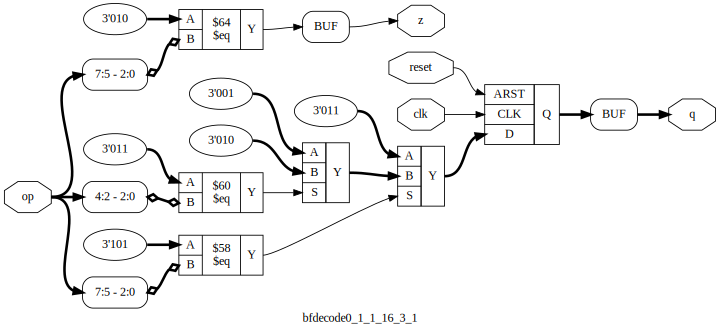

In [56]:
from ys_aux import to_svg
display(to_svg(design))

### Simulation

Run the top level blackbox as MyHDL simulation:

In [55]:
tb = test_design(bfdecode0)
tb.config_sim(trace=True)
tb.run_sim(200)
tb.quit_sim()

01 False
03 False
03 True
02 False


<class 'myhdl._SuspendSimulation'>: Simulated 200 timesteps


### Next: [Hardware programming](hwprog_setup.ipynb)